<a href="https://colab.research.google.com/github/shadenWq/sentiment-analysis-/blob/main/Copy_of_TextCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import Dataset

In [ ]:
# Read the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

## Data Pre-proccessing

In [ ]:
import nltk
import re #regular expression to clean data
from nltk.corpus import stopwords #stop word
nltk.download('stopwords') #corpus for stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import spacy

# Load the English model with spaCy's POS tagging from spaCy
modelspacy = spacy.load("en_core_web_sm")#load once

# Function to lemmatize text with spaCy
def lemmatize_text(text):
    # Process the text using spaCy, create Doc object
    docForLemmatization = modelspacy(text) #it includes tokenization and POS tagging

    # Lemmatize tokens, use "lemma_" attribute to get the lemma of each token
    lemmatized_tokens = [token.lemma_ for token in docForLemmatization]
    # and join them back into a single string
    return " ".join(lemmatized_tokens)

In [ ]:
def text_cleaning(text):

    text = text.lower() # Convert to lowercase

    text = re.sub(r'@[\S]+', '', text) # Remove usernames "sub" replacing substrings

    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove hyperlinks

    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove punctuation


    stop_words = set(stopwords.words('english')) # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = lemmatize_text(text)# Lemmatize text

    return text

## TextCNN

In [ ]:
import keras
import keras.layers as L
from collections import Counter

split the data into two files : neg and pos

In [ ]:
# Create a list of tuples from the DataFrame
dataset = [(row['post_text'], row['label']) for inde, row in df.iterrows()]

In [ ]:
# Assuming `dataset` is a list of tuples where the first element is the text data and the second element is the label
for sample in dataset:
    text_data = sample[0] #first element
    label = sample[1] #seconn element

    # Determine the file name based on the label
    file_name = "positive_data.txt" if label == 0 else "negative_data.txt"

    # Append the text data to the appropriate file
    with open(file_name, "a") as f:
        f.write(text_data + "\n")

In [ ]:
def load_data_and_labels(positive_data_file, negative_data_file):
    # Load data from files
    positive_examples = list(open(positive_data_file, "r", encoding='utf-8').readlines())
    negative_examples = list(open(negative_data_file, "r", encoding='utf-8').readlines())
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [text_cleaning(sent) for sent in x_text]
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels])
    return [x_text, y]

In [ ]:
# Load data and labels from positive and negative data files
x_text, y = load_data_and_labels('/content/positive_data.txt', '/content/negative_data.txt')

In [ ]:
# Tokenize each document in the dataset by splitting them into individual words
tokens = [t for doc in x_text for t in doc.split(' ')]
# Print the total number of tokens in the dataset
print("Total tokens in the data set: ", len(tokens))

# Count the frequency of each token using Counter
counter = Counter(tokens)
# Create a list of unique tokens (vocabulary)
index2word = list(counter.keys())

# Insert a special token 'PAD' at the beginning of the vocabulary list for padding
index2word.insert(0, 'PAD')
# Print the vocabulary size, including the 'PAD' token
print("Vocabulary size in data set (contains 'PAD' as first): ", len(index2word))

Total tokens in the data set:  135716
Vocabulary size in data set (contains 'PAD' as first):  16870


In [ ]:
def as_matrix(sequences, max_len, index2word):
    # Initialize a matrix with zeros to store the word indices
    matrix = np.full((len(sequences), max_len), 0)

    # Iterate over each sequence in the input sequences
    for i, seq in enumerate(sequences):
        # Convert each word in the sequence to its corresponding index in the vocabulary
        row_ix = [index2word.index(w) for w in seq.split(' ')]

        # Assign the word indices to the matrix row, ensuring it doesn't exceed max_len
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
max_doc_length = max([len(x.split(' ')) for x in x_text])
# Print the maximum document length
print("Max document length: ", max_doc_length)

Max document length:  26


In [ ]:
# Convert the text data into matrix format using the provided vocabulary
x_matrix = as_matrix(x_text, max_doc_length, index2word)

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing subsets using train_test_split function
x_train, x_test, y_train, y_test = train_test_split(x_matrix, y, test_size= 0.1)

Define TextCNN model

In [ ]:
# Hyperprameters
num_classes = 2
embedding_size = 300 #vector of length 300 in the embedding space.
filter_sizes = (3, 4, 5)
num_filters = 128

sequence_length = x_train.shape[1]
vocab_size = len(index2word)
drop_out=0.5
l2_reg_lambda=0.0

In [ ]:
x_train.shape

(20784, 26)

In [ ]:
# Define the input layer
input_x = L.Input(shape=(sequence_length,), name='input_x')

# Embedding layer
# Initialize embedding layer with random weights if no pre-trained embeddings are provided
embedding = L.Embedding(vocab_size, embedding_size, name='embedding')(input_x)

# Reshape the embedding layer to match the expected input shape for convolutional operations
expend_shape = [embedding.get_shape().as_list()[1], embedding.get_shape().as_list()[2], 1]
embedding_chars = L.Reshape(expend_shape)(embedding)

# Convolutional and max pooling layers
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
        # Convolutional layer with ReLU activation
    conv = L.Conv2D(filters=num_filters,
                    kernel_size=[filter_size, embedding_size],
                    strides=1,
                    padding='valid',
                    activation='relu',
                    kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1),
                    bias_initializer=keras.initializers.constant(value=0.1),
                    name=('conv_%d' % filter_size))(embedding_chars)
# Max pooling layer
    max_pool = L.MaxPool2D(pool_size=[sequence_length - filter_size + 1, 1],
                            strides=(1, 1),
                            padding='valid',
                            name=('max_pool_%d' % filter_size))(conv)

    pooled_outputs.append(max_pool)

# Combine pooled features
num_filters_total = num_filters * len(filter_sizes)
h_pool = L.Concatenate(axis=3)(pooled_outputs)
h_pool_flat = L.Reshape([num_filters_total])(h_pool)

# Dropout layer to prevent overfitting
dropout = L.Dropout(drop_out)(h_pool_flat)

# Output layer for classification
output = L.Dense(num_classes,
                  kernel_initializer='glorot_normal',
                  bias_initializer=keras.initializers.constant(0.1),
                  activation='softmax',
                  name='output')(dropout)

# Define the model with input and output layers
model = keras.models.Model(inputs=input_x, outputs=output)

##TextCNN Result

In [ ]:
cnn_rand = model
cnn_rand.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
cnn_rand_history = cnn_rand.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
163/163 [==============================] - 27s 113ms/step - loss: 0.5488 - accuracy: 0.6953
Epoch 2/10
163/163 [==============================] - 5s 32ms/step - loss: 0.3148 - accuracy: 0.8609
Epoch 3/10
163/163 [==============================] - 4s 24ms/step - loss: 0.2008 - accuracy: 0.9171
Epoch 4/10
163/163 [==============================] - 4s 24ms/step - loss: 0.1446 - accuracy: 0.9398
Epoch 5/10
163/163 [==============================] - 2s 12ms/step - loss: 0.1106 - accuracy: 0.9538
Epoch 6/10
163/163 [==============================] - 3s 17ms/step - loss: 0.0910 - accuracy: 0.9637
Epoch 7/10
163/163 [==============================] - 2s 9ms/step - loss: 0.0793 - accuracy: 0.9680
Epoch 8/10
163/163 [==============================] - 2s 12ms/step - loss: 0.0714 - accuracy: 0.9714
Epoch 9/10
163/163 [==============================] - 2s 11ms/step - loss: 0.0657 - accuracy: 0.9732
Epoch 10/10
163/163 [==============================] - 2s 13ms/step - loss: 0.0612 - accur

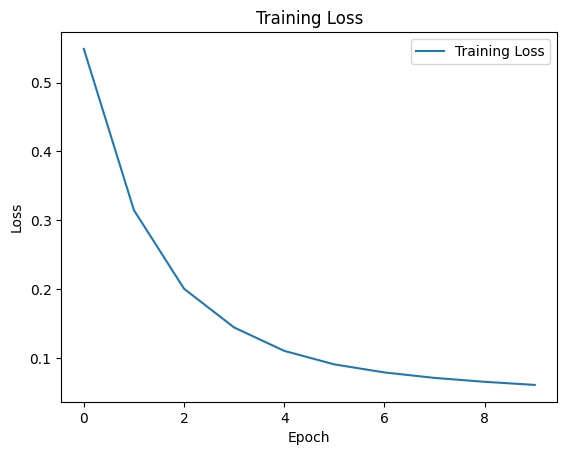

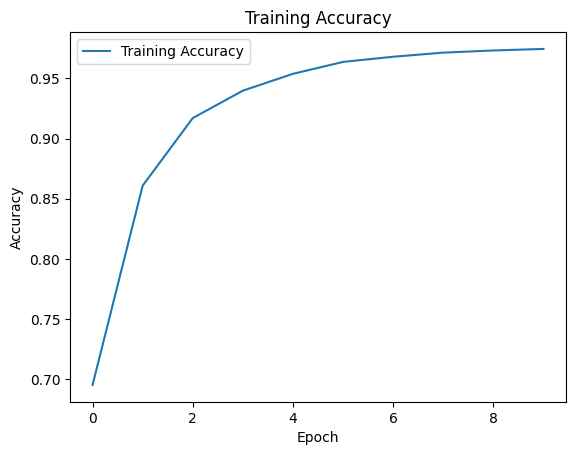

In [ ]:
# Plot training loss
plt.plot(cnn_rand_history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(cnn_rand_history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()